In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'metrics')
sys.path.append(source_path)
import matplotlib.pyplot as plt

from dl import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split
)
from metrics import calc_spread_return_sharpe

Global seed set to 42
Global seed set to 42


In [2]:
computer_name1 = 'gilbe'
computer_name2 = 'Gilberto-BE'

ROOT_PATH = f'c:/Users/{computer_name1}/Documents/TokyoData'


'/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv'
'/train_files/trades.csv'

train_df = pd.read_csv(f'{ROOT_PATH}/train_files/stock_prices.csv')
train_df['Date'] = pd.to_datetime(train_df['Date']) 
train_df.set_index('Date', inplace=True)
# train_df = date_features(train_df)
print(train_df.head(2))

train_options = pd.read_csv(f'{ROOT_PATH}/train_files/options.csv', low_memory=False)
train_financials = pd.read_csv(f'{ROOT_PATH}/train_files/financials.csv', low_memory=False)
train_trades = pd.read_csv(f'{ROOT_PATH}/train_files/trades.csv', low_memory=False)

                    RowId  SecuritiesCode    Open    High     Low   Close  \
Date                                                                        
2017-01-04  20170104_1301            1301  2734.0  2755.0  2730.0  2742.0   
2017-01-04  20170104_1332            1332   568.0   576.0   563.0   571.0   

             Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
Date                                                                       
2017-01-04    31400               1.0               NaN            False   
2017-01-04  2798500               1.0               NaN            False   

              Target  
Date                  
2017-01-04  0.000730  
2017-01-04  0.012324  


In [8]:
# n_stocks = train_df.SecuritiesCode.nunique()
# n_stocks = train_df.SecuritiesCode.unique()
# for n in n_stocks:
#     print(train_df[train_df['SecuritiesCode'] == n].shape)

##  Get Data and train a Neural Network

Raw Time Series data shape: (2332531, 11)
No Unique Securities code: 2000
df_1301.head()
                    RowId    Open    High     Low   Close  AdjustmentFactor  \
Date                                                                          
2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0               1.0   
2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0               1.0   

            ExpectedDividend  SupervisionFlag   Target  
Date                                                    
2017-01-04               NaN            False  0.00073  
2017-01-05               NaN            False  0.00292  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1202 entries, 2017-01-04 to 2021-12-03
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RowId             1202 non-null   object 
 1   Open              1201 non-null   float64
 2   High              1201 non-null   float64
 3   Lo

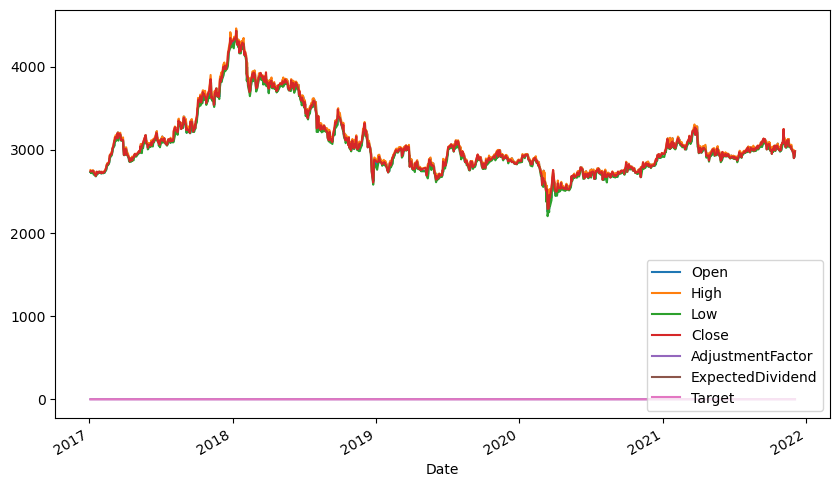

categorical shape: (1202, 4)
xtrain.shape: (900, 1)
[[-0.00145879]
 [ 0.00073046]
 [ 0.00291971]
 [-0.0010917 ]
 [-0.00510018]]

ytrain.shape: (901, 1)
[[ 0.00073046]
 [ 0.00291971]
 [-0.0010917 ]
 [-0.00510018]
 [-0.0032955 ]]
df_train_cat.shape: (901, 4)
            day_of_year  month  day_of_week  RowId
Date                                              
2017-01-04            4      1            4    0.0
2017-01-05            5      1            5    1.0
2017-01-06            6      1            6    2.0
2017-01-10           10      1           10    3.0
2017-01-11           11      1           11    4.0


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['RowId'] = enc.fit_transform(df['RowId'].to_numpy().reshape(-1, 1))


' xtrain and df_train_cat have different shapes!!!!!'

In [3]:



print('Raw Time Series data shape:', train_df.shape)
print('No Unique Securities code:', train_df['SecuritiesCode'].nunique())

df_1301 = train_df[train_df['SecuritiesCode'] == 1301].drop(['SecuritiesCode', 'Volume'], axis=1)

print('df_1301.head()')
print(df_1301.head(2))
print(df_1301.info())

df_1301.plot(figsize=(10, 6));
plt.show();

df_1301 = date_features(df_1301)


""" 
Add RowId as extra catcol.
"""
# cont, cat = cont_cat_split(df_1301, 'int64')
cat_cols = ['day_of_year', 'month', 'day_of_week', 'RowId']
cont, cat = cont_cat_split(df_1301, cat_cols=cat_cols)
print('categorical shape:', cat.shape)

df_train_cat, df_val_cat = ts_split(cat)
df_train, df_val = ts_split(cont)

xtrain, ytrain = preprocess(df_train, 'Target', 1, continous_cols=['Close'])
xval, yval = preprocess(df_val, 'Target', 1, continous_cols=['Close'])

print('xtrain.shape:', xtrain.shape)
print(xtrain[:5])
print()
print('ytrain.shape:', ytrain.shape)
print(ytrain[:5])
print('df_train_cat.shape:', df_train_cat.shape)
print(df_train_cat.head())

""" xtrain and df_train_cat have different shapes!!!!!"""

### Train the model

In [4]:

%%time
import torch
from sklearn.impute import SimpleImputer


imp = SimpleImputer(missing_values=np.nan, strategy='mean')
batch_size = 64
train_dataloader = get_loader(x=xtrain, y=ytrain, batch_size=batch_size, x_cat=df_train_cat.to_numpy())
val_dataloader = get_loader(x=xval, y=yval, batch_size=batch_size, x_cat=df_val_cat.to_numpy())


CAT_FEATURES = cat.shape[1]
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 10
NO_EMBEDDING = 2 * len(df_train_cat)
# cat_features = cat_features * embedding_dim
# print('in_features:', xtrain.shape[1] + cat_features)

model = NeuralNetwork(
    in_features=xtrain.shape[1], 
    units=500,
    out_features=1, 
    categorical_dim=CAT_FEATURES,
    no_embedding=NO_EMBEDDING, 
    emb_dim=EMBEDDING_DIM
)

print(model)

trainer = Trainer(model, lr=3.3e-6)
trainer.fit_epochs(
    train_dataloader, 
    val_dataloader, 
    use_cyclic_lr=True, 
    x_cat=True, 
    epochs=25
)


C:\Users\gilbe\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\__init__.py:145: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:219.)
  Variable._execution_engine.run_backward(


CAT_FEATURES: 4
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (embedding): Embedding(1802, 10)
  (embedding_to_hidden): Linear(in_features=10, out_features=500, bias=True)
  (embedding_output): Linear(in_features=500, out_features=1, bias=True)
  (cont_input): Linear(in_features=1, out_features=500, bias=True)
  (hidden_layer): Linear(in_features=504, out_features=504, bias=True)
  (output_layer): Linear(in_features=504, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (position_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
Using cpu-device
Epoch: <<< 0 >>>
Train-Loss: 0.08581766486167908 [0/15]

Train-Loss: 0.06437800824642181 [1/15]
train metrics: <<< {'mse': 0.06437800824642181, 'mae': 0.18796707689762115} >>>

Train-Loss: 2.4641058444976807 [2/15]
train metrics: <<< {'mse': 2.4641058444976807, 'mae': 1.5477255582809448} >>>

Train-Loss: 2.035799026489258 [3/15]
train metrics: <<< {'mse': 2.035799026489258, 'mae'